## Importing libraries and datasets

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import warnings # This is a library that handles warnings.


warnings.filterwarnings("ignore")# Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')# This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API Key
quandl.ApiConfig.api_key = 'g1nu-FaTnPsMq-uc1h6p'

In [3]:
# Importing the Federal Reserve Economic Data "personal consumption expenditures" variable.

data = quandl.get('FRED/PCE')

This variable measures the total spending by individuals on goods and services. Higher personal consumption expenditures could indicate a stronger economy and potentially higher demand for travel and accommodations, including Airbnb listings.

However, the Federal Reserve Economic Data set does not include a variable that tracks the area or region for Real Median Household Income in the United States. Therefore, our analysis will focus solely on the Real Median Household Income data over time

In [4]:
data.head(5) # Ensuring the “Date” column (or any equivalent temporal variable) is the index in your dataframe will make your analysis much easier.

,Value
Date,
1959-01-01,306.1
1959-02-01,309.6
1959-03-01,312.7
1959-04-01,312.2
1959-05-01,316.1


In [5]:
data.shape

(756, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

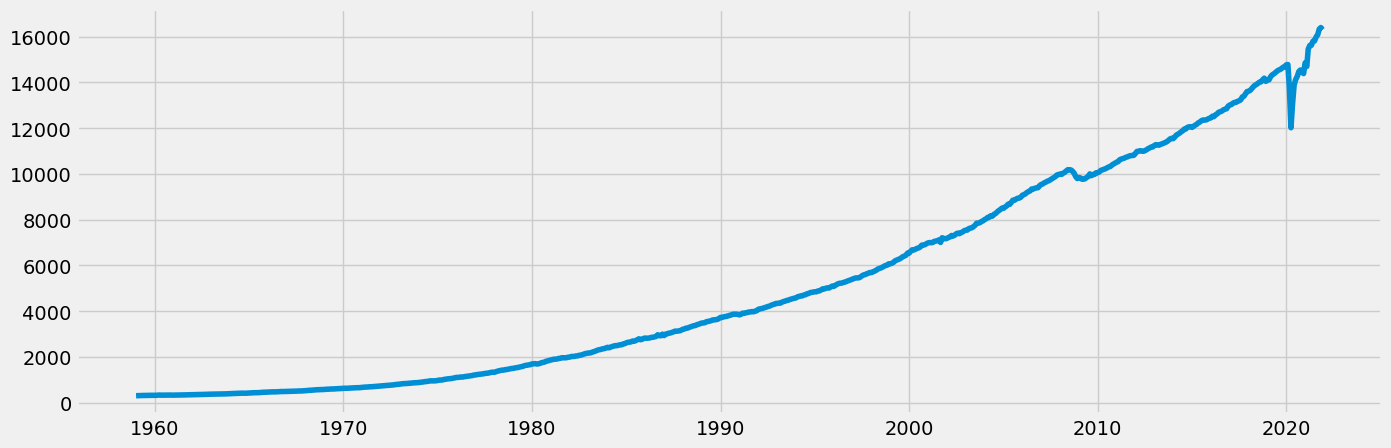

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1959-01-01,306.1
1,1959-02-01,309.6
2,1959-03-01,312.7
3,1959-04-01,312.2
4,1959-05-01,316.1


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01')]

In [12]:
data_sub.shape

(264, 2)

In [13]:
data_sub.head()

,Date,Value
492,2000-01-01,6542.9
493,2000-02-01,6625.3
494,2000-03-01,6686.5
495,2000-04-01,6679.1
496,2000-05-01,6709.7


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-01-01,6542.9
2000-02-01,6625.3
2000-03-01,6686.5
2000-04-01,6679.1
2000-05-01,6709.7


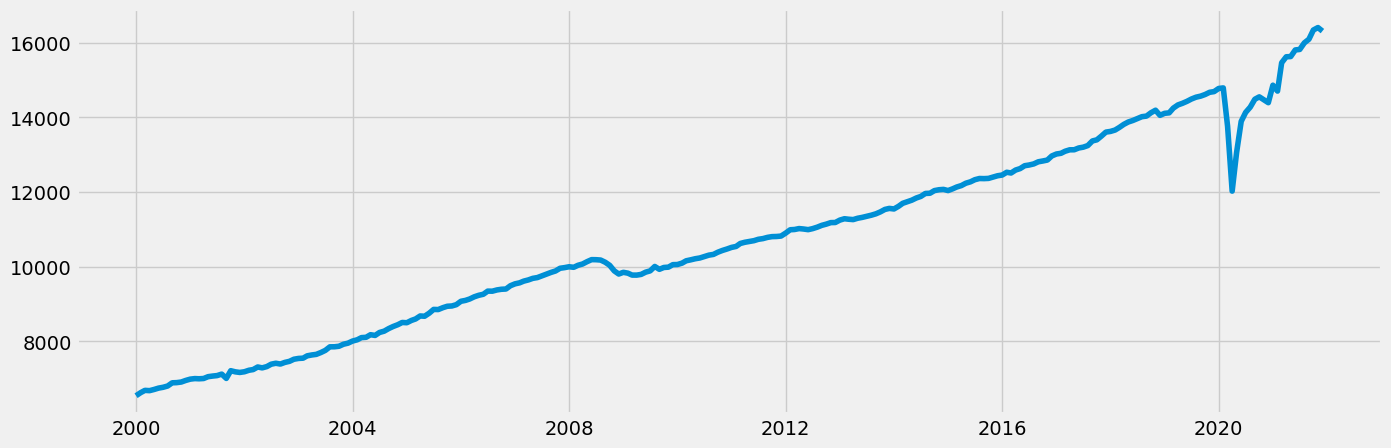

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

There is an upward trend visible, however, there's a sharp decline in 2020, followed by a subsequent increase.

In [16]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

## 3. Time-series analysis: decomposition


In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

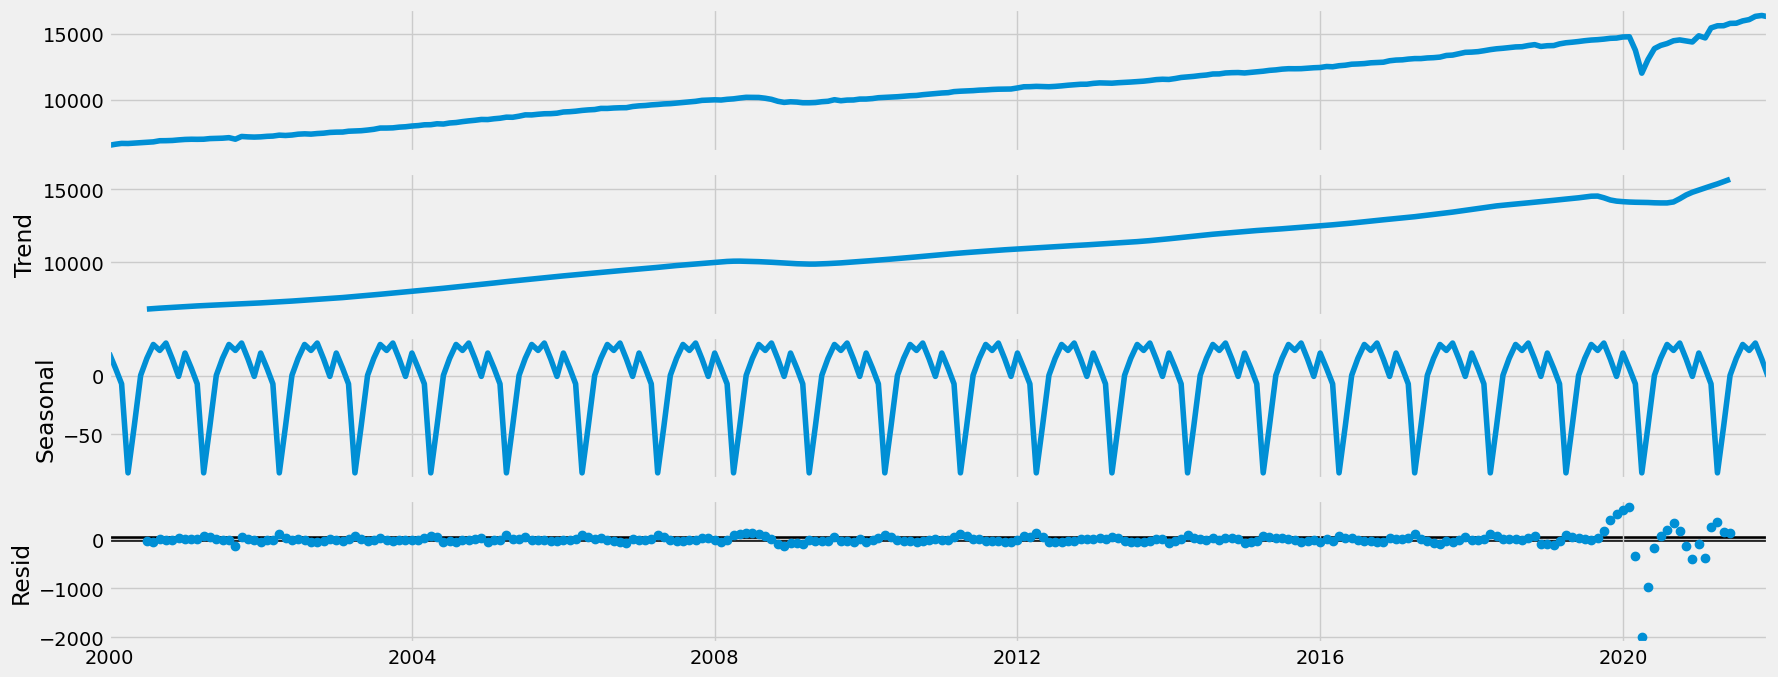

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

## 4. Testing for stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.125231
p-value                          0.995426
Number of Lags Used             11.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


Using 5% significance level: CV of -2.873559< TS of -0.604791. Test statistic larger than critical value = can’t reject null hypothesis.

There is a unit root in the data (non-stationary)!

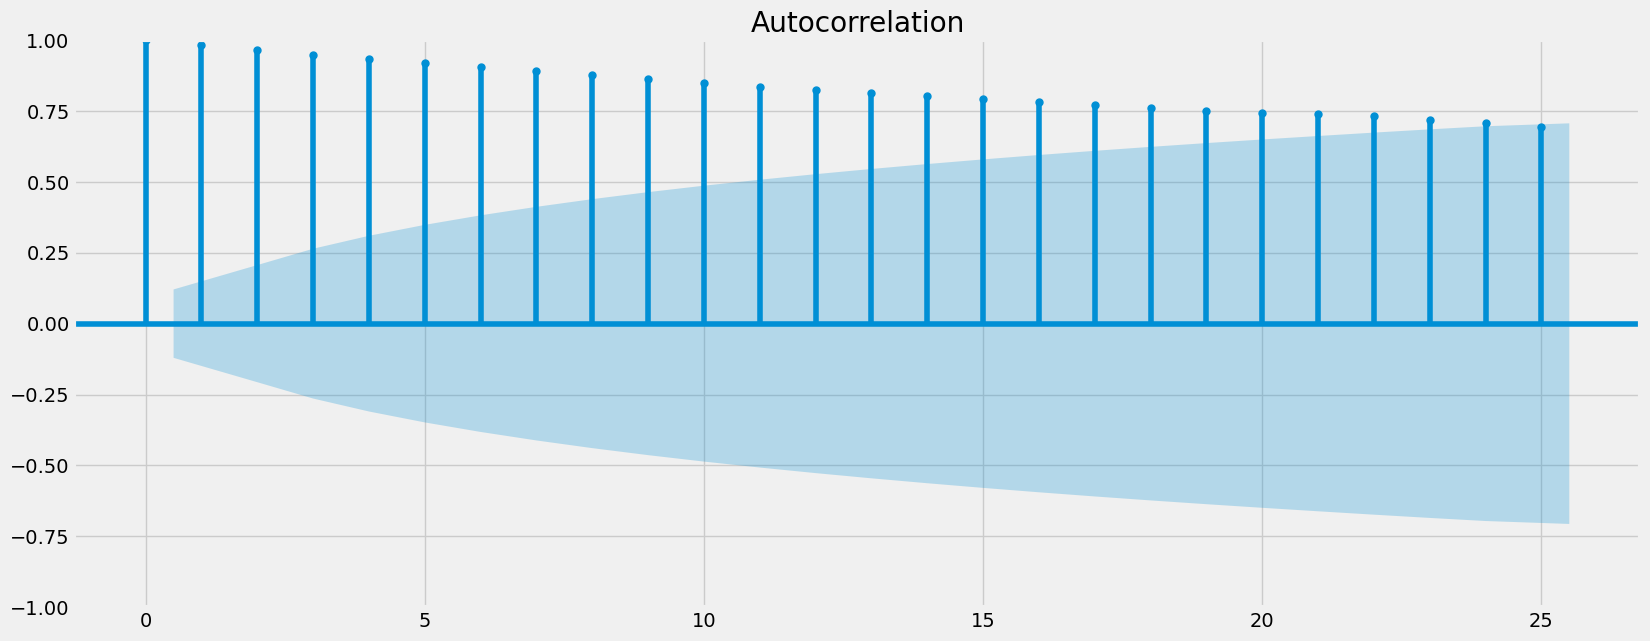

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The time series has quite a few lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test you conducted earlier.

## 5. Stationarizing the Federal Reserve Economic Data

In [23]:

data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,Value
datetime,
2000-02-01,82.4
2000-03-01,61.2
2000-04-01,-7.4
2000-05-01,30.6
2000-06-01,37.2


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

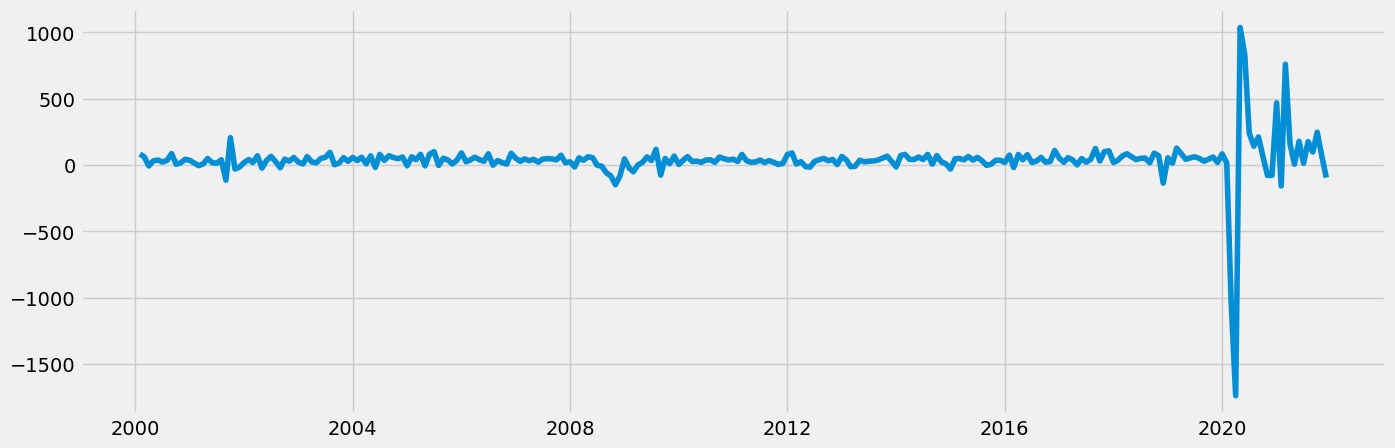

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -5.108730
p-value                          0.000013
Number of Lags Used             10.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


Critical Value (5%) and (10%) is > Test statistics -> can reject the null hypothesis -> stationarity 

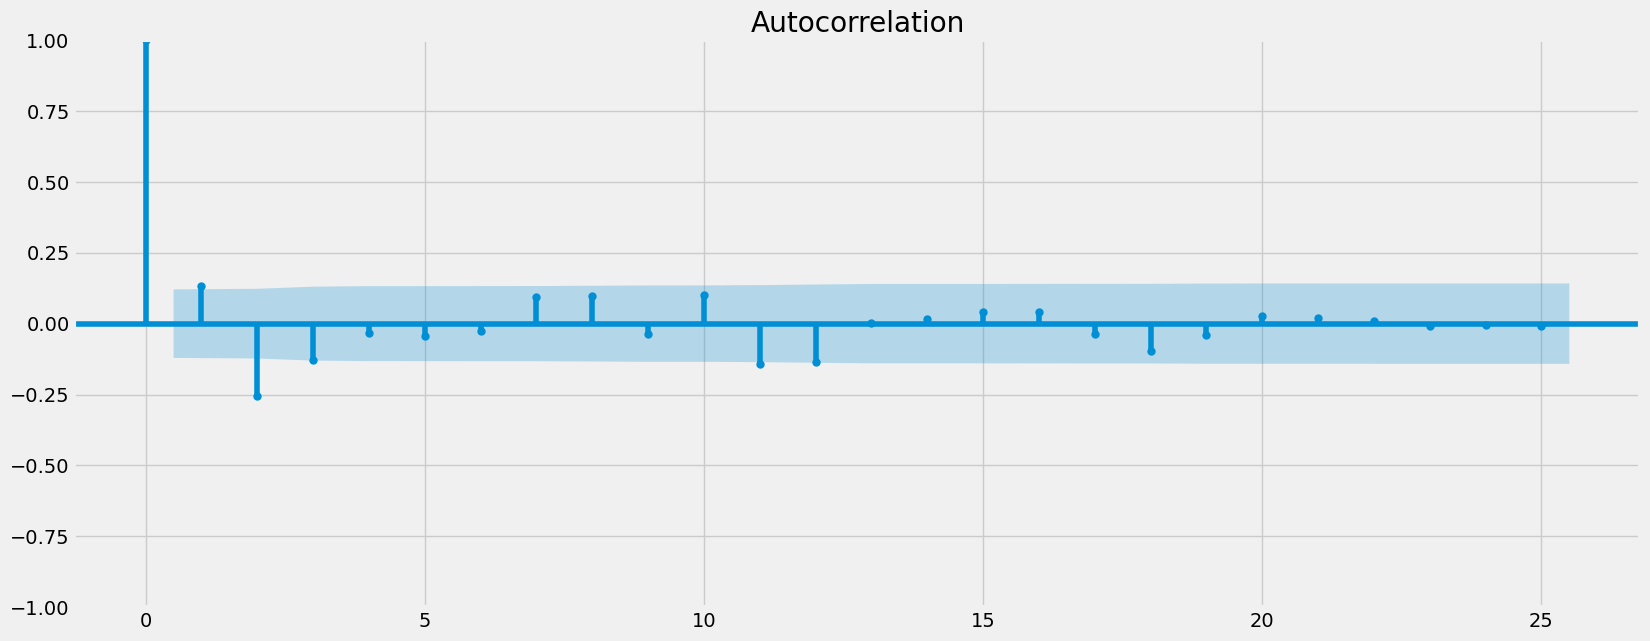

In [29]:
plot_acf(data_diff)
plt.show()

## Conclusion 

After applying the Differencing method to stabilize the PCE time series data, we found that our test statistic is now less than the critical value at both the five and ten percent significance levels. Therefore, we can reject the null hypothesis, leading us to consider the PCE data series as stationary.

However, even though there's an improvement in the autocorrelation plot with fewer autocorrelated terms, it's not entirely perfect. This suggests that, despite the Dickey-Fuller test indicating stationarity, the stationarity of the data is somewhat weak.